In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import random
import time

%config Completer.use_jedi = False

# for shit with my gpu /Janosch
from tensorflow import compat
def configure_gpu_options():
    config = compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = compat.v1.Session(config=config)
    compat.v1.keras.backend.set_session(sess)

In [ ]:
EPOCHS = 20
DS_SPLIT = 701
BATCH_SIZE = 32

# Helpers

In [2]:
class Timer():
    """
    A small class for making timings.
    """
    def __init__(self):
        self._start_time = None

    def start(self):
        """
        Start a new timer
        """
        self._start_time = time.perf_counter()

    def stop(self):
        """
        Stop the timer, and report the elapsed time
        """
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
            return 0
    
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        return elapsed_time  

# Preprocess Data

In [3]:
gtzan_info = pd.read_csv('data/gtzan/features_30_sec.csv')
gtzan_data = gtzan_info.loc[:, 'chroma_stft_mean':'mfcc20_var'].to_numpy()
gtzan_labels = np.expand_dims(gtzan_info.loc[:, 'label'].to_numpy(), axis=1)

# Standardize the data
gtzan_mean = np.expand_dims(np.mean(gtzan_data, axis=0), axis=0)
gtzan_std = np.expand_dims(np.std(gtzan_data, axis=0), axis=0)
gtzan_data = (gtzan_data-gtzan_mean)/gtzan_std

# one_hot encode labels
encoder = OneHotEncoder()
gtzan_targets = encoder.fit_transform(gtzan_labels).toarray()

data_shape = gtzan_data.shape[-1]
classes = gtzan_targets.shape[-1]

In [4]:
def create_tfds(inputs, targets, batch_size=None, buffer_size=None, prefetch_factor=None):
    '''
    Create an input pipeline from tf.dataset. 
    Adjusted to only take input as there are no labels for autoencoders.
    ''' 
    dataset = tf.data.Dataset.from_tensor_slices((inputs, targets))

    if not buffer_size is None:
        dataset = dataset.shuffle(buffer_size)
    
    if not batch_size is None:
        dataset = dataset.batch(batch_size)        
    
    if not prefetch_factor is None:
        dataset = dataset.prefetch(prefetch_factor)
    
    return dataset

ds_split = DS_SPLIT
batch_size = BATCH_SIZE

gtzan_train = create_tfds(gtzan_data[:ds_split], gtzan_targets[:ds_split], 
                          batch_size=batch_size, 
                          buffer_size=1024, 
                          prefetch_factor=tf.data.experimental.AUTOTUNE)

gtzan_test = create_tfds(gtzan_data[ds_split:], gtzan_targets[ds_split:], 
                         batch_size=batch_size, 
                         buffer_size=1024, 
                         prefetch_factor=tf.data.experimental.AUTOTUNE)

In [5]:
for x, y in gtzan_train.take(1):
    print(x.shape, y.shape)

(16, 57) (16, 10)


# Create Model

In [6]:
class Classifier(tf.keras.Model): 
    def __init__(self, classes, act_fct='relu', out_act='softmax'):
        super(Classifier, self).__init__()
        self.hidden_layers = []
        
        units = [256, 128, 64, 32]
        
        for i in range(len(units)-1):
            self.hidden_layers.append(tf.keras.layers.Dense(units=units[i]))
            self.hidden_layers.append(tf.keras.layers.BatchNormalization())
            self.hidden_layers.append(tf.keras.layers.Activation(act_fct))
        
        self.output_layer = tf.keras.layers.Dense(units=classes,
                                                  activation=out_act, 
                                                  use_bias=False)
                                               
    def call(self, x, training=False):
        for l in self.hidden_layers:
            try:
                x = l(x, training)
            except:
                x = l(x)

        return self.output_layer(x)

In [7]:
# initialize the model and specify parameters
tf.keras.backend.clear_session()
configure_gpu_options()

learning_rate = 1e-4

# Initialize the model.
model = Classifier(classes)
model.build((batch_size, data_shape))
model.summary()
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()#SGD(learning_rate, momentum=0.9)

# prepare metrics
train_acc_metric = tf.keras.metrics.CategoricalAccuracy('train_accuracy')
train_loss_metric = tf.keras.metrics.Mean('train_loss')
test_acc_metric = tf.keras.metrics.CategoricalAccuracy('test_accuracy')
test_loss_metric = tf.keras.metrics.Mean('test_loss')

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

Model: "classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  14848     
_________________________________________________________________
batch_normalization (BatchNo multiple                  1024      
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  32896     
_________________________________________________________________
batch_normalization_1 (Batch multiple                  512       
_________________________________________________________________
activation_1 (Activation)    multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  8

# Train the model

In [8]:
@tf.function
def train(model, ds, loss_function, optimizer, train_loss_metric, train_acc_metric):
    for x, target in ds:
        with tf.GradientTape() as tape:
            prediction = model(x)
            loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        # update metrics
        train_loss_metric.update_state(loss)
        train_acc_metric.update_state(target, prediction)

@tf.function
def test(model, ds, loss_function, loss_metric, acc_metric):
    for x, target in ds:
        prediction = model(x)
        loss = loss_function(target, prediction)

        # update metrics
        loss_metric.update_state(loss)
        acc_metric.update_state(target, prediction)        

In [9]:
def eval_metric(metric, val_list):
    result = metric.result()
    metric.reset_states()
    val_list.append(result)
    return result

In [10]:
timer = Timer()
times = []
epochs = EPOCHS
    
test(model, gtzan_train, loss_function, train_loss_metric, train_acc_metric)
test(model, gtzan_train, loss_function, test_loss_metric, test_acc_metric)

# Evaluating metrics
eval_metric(train_loss_metric, train_losses)
eval_metric(train_acc_metric, train_accuracies)
eval_metric(test_loss_metric, test_losses)
eval_metric(test_acc_metric, test_accuracies)

for epoch in range(epochs):    
    # training step with metrics update--------------------------------------------------------
    timer.start()
    train(model, gtzan_train, loss_function, optimizer, train_loss_metric, train_acc_metric)
    test(model, gtzan_train, loss_function, test_loss_metric, test_acc_metric)
    
    # Evaluating metrics
    train_loss = eval_metric(train_loss_metric, train_losses)
    train_acc = eval_metric(train_acc_metric, train_accuracies)
    test_loss = eval_metric(test_loss_metric, test_losses)
    test_acc = eval_metric(test_acc_metric, test_accuracies)   
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)

    if epoch%5 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(epochs-epoch-1)/60:0.4f} min.\n')

    print(f'[Epoch {epoch}] - deltaT: {elapsed_time:0.2f}s - train_loss: {train_loss:0.4f} - train_acc: {train_acc:0.4f} - test_loss: {test_loss:0.4f}, test_acc: {test_acc:0.4f}')


[INFO] - Total time elapsed: 0.0070 min. Total time remaining: 0.1331 min.

[Epoch 0] - deltaT: 0.42s - train_loss: 1.4634 - train_acc: 0.5207 - test_loss: 0.7866, test_acc: 0.7489
[Epoch 1] - deltaT: 0.15s - train_loss: 0.6865 - train_acc: 0.7746 - test_loss: 0.4442, test_acc: 0.8631
[Epoch 2] - deltaT: 0.16s - train_loss: 0.4589 - train_acc: 0.8474 - test_loss: 0.3166, test_acc: 0.9016
[Epoch 3] - deltaT: 0.16s - train_loss: 0.3069 - train_acc: 0.9087 - test_loss: 0.2073, test_acc: 0.9558
[Epoch 4] - deltaT: 0.16s - train_loss: 0.2274 - train_acc: 0.9301 - test_loss: 0.1569, test_acc: 0.9672

[INFO] - Total time elapsed: 0.0201 min. Total time remaining: 0.0468 min.

[Epoch 5] - deltaT: 0.16s - train_loss: 0.1692 - train_acc: 0.9515 - test_loss: 0.1266, test_acc: 0.9700
[Epoch 6] - deltaT: 0.15s - train_loss: 0.1245 - train_acc: 0.9643 - test_loss: 0.0774, test_acc: 0.9857
[Epoch 7] - deltaT: 0.15s - train_loss: 0.0928 - train_acc: 0.9729 - test_loss: 0.0496, test_acc: 0.9971
[Epoch

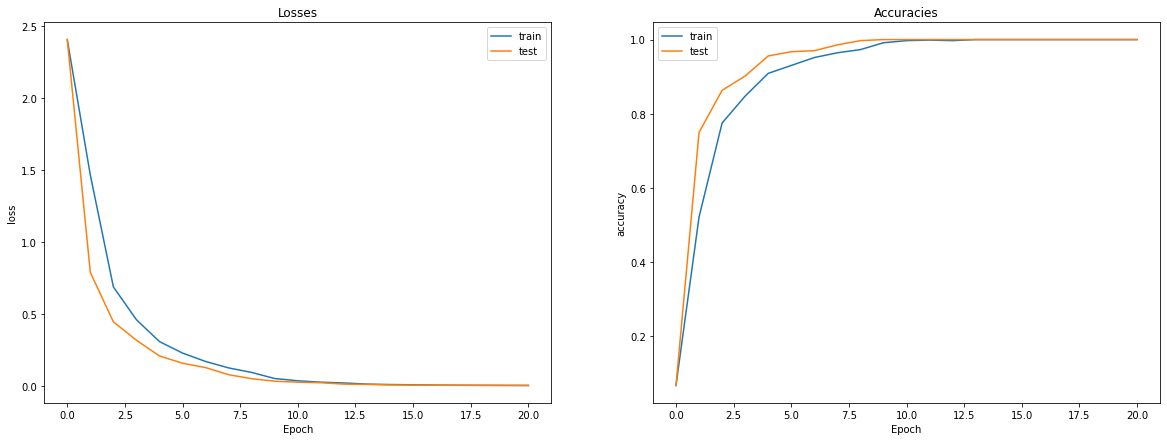

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

x = np.arange(len(train_losses))

# losses
axes[0].plot(x, train_losses, label='train')
axes[0].plot(x, test_losses, label='test')
axes[0].legend()
axes[0].set(title='Losses', xlabel='Epoch', ylabel='loss')

# accuracies
axes[1].plot(x, train_accuracies, label='train')
axes[1].plot(x, test_accuracies, label='test')
axes[1].legend()
axes[1].set(title='Accuracies', xlabel='Epoch', ylabel='accuracy')

plt.show()